# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as t
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.nn.init import xavier_normal_ as xavier
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler 

import os
import time
import json
import numpy as np
from PIL import Image
from shutil import copyfile
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
cuda_available = torch.cuda.is_available()
print("Training will be done on GPU: {}".format(cuda_available))

random_seed = 41
torch.manual_seed(random_seed)
np.random.seed(random_seed)
if cuda_available:
    torch.cuda.manual_seed(random_seed)

Training will be done on GPU: True


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
"""

Create test dataset
"""

test_base_folder = './flower_data/test'
if not os.path.isdir(test_base_folder):
    os.makedirs(test_base_folder)
test_image_per_class = 10
for n in os.listdir(train_dir):
    if not os.path.isdir(os.path.join(test_base_folder, n)):
        os.makedirs(os.path.join(test_base_folder, n))
    i = 0
    for img in os.listdir(os.path.join(train_dir, n)):
        src = os.path.join(train_dir, n, img)
        dst = os.path.join(test_base_folder, n, img)
#         copyfile(src, dst)
#         os.remove(src)
        i+=1
        if i == test_image_per_class: break

## Look at the number of images per class

In [5]:
train_data_set = ImageFolder(train_dir)
valid_data_set = ImageFolder(valid_dir)
test_data_set  = ImageFolder(test_dir)

print("Number of classes: {}".format(len(train_data_set.classes)))
print("\nTraining images: {}\nValidation images: {}\nTest image: {}"
      .format(len(train_data_set), len(valid_data_set), len(test_data_set)))

Number of classes: 102

Training images: 5532
Validation images: 818
Test image: 1020


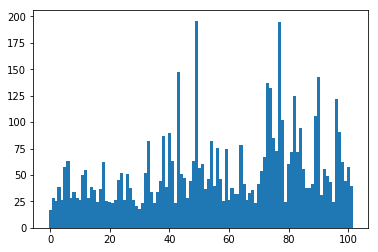

In [6]:
imgs = np.asarray(train_data_set.imgs)
d = {}
for img, label in imgs:
    if label in d: d[label] += 1
    else: d[label] = 1      
x = [int(el) for el in d.keys()]
y = [d[el] for el in d.keys()]
plt.bar(x, y, 1.05)
plt.show()

In [7]:
def make_weights_for_balanced_classes(images, n_classes):
    """
    Since the classes are not balanced let's create weights for them
    
    """
    count = [0] * n_classes
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * n_classes
    N = float(sum(count))
    for i in range(n_classes):
        weight_per_class[i] = N/float(count[i])
    weights = [0] * len(images)
    for idx, val in enumerate(images):
        weights[idx] = weight_per_class[val[1]]
    return weights


def get_transforms(train, hf=0.5, rr_degrees=30, gs=0.3,
                   mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if train:
        return t.Compose([
            t.Resize(256),
            t.RandomHorizontalFlip(p=hf),
            t.RandomRotation(degrees=rr_degrees),
            t.RandomGrayscale(p=gs),
            t.RandomCrop(224),
            t.ToTensor(),
            t.Normalize(mean=mean, std=std),
        ])
    else:
        return t.Compose([
                t.Resize(256),
                t.CenterCrop(224),
                t.ToTensor(),
                t.Normalize(mean=mean, std=std),
            ])

    
def get_data_set(train_dir, valid_dir, test_dir):
    train_data_set = ImageFolder(root=train_dir, transform=get_transforms(train=True))
    valid_data_set = ImageFolder(root=valid_dir, transform=get_transforms(train=False))
    test_data_set = ImageFolder(root=test_dir, transform=get_transforms(train=False))
    return train_data_set, valid_data_set, test_data_set
    

def get_data_loaders_for_test(train_data_set, indices_step=100, training_valid_split=0.1, 
                              train_batch_size=16, valid_batch_size=16, cuda_available=False):
    dataset_len = len(train_data_set)
    indices = list(np.arange(0, dataset_len, indices_step))
    split = int(np.floor(len(indices) * training_valid_split))
    train_indices = indices[split:]
    valid_indices = indices[:split]
    # Get data subsets
    tmp_train_data_set = Subset(train_data_set, train_indices)
    tmp_valid_data_set = Subset(train_data_set, valid_indices)
    # Create data loaders
    train_data_loader = DataLoader(dataset=tmp_train_data_set,
                                   batch_size=train_batch_size,
                                   num_workers=4,
                                   pin_memory=cuda_available)
    valid_data_loader = DataLoader(dataset=tmp_valid_data_set,
                                   batch_size=valid_batch_size,
                                   num_workers=4,
                                   pin_memory=cuda_available)
    print("Number of training   batches: {}".format(len(train_data_loader)))
    print("Number of validation batches: {}".format(len(valid_data_loader)))
    return train_data_loader, valid_data_loader
    
    
def get_full_data_loaders(train_data_set, valid_data_set, test_data_set, train_batch_size=16, 
                          valid_batch_size=16, cuda_available=False):
    
    weights = make_weights_for_balanced_classes(train_data_set.imgs, len(train_data_set.classes))
    weights = torch.DoubleTensor(weights)
    sampler = WeightedRandomSampler(weights, len(weights))
    
    train_data_loader = DataLoader(dataset=train_data_set,
                                   sampler=sampler,
                                   batch_size=train_batch_size,
                                   num_workers=4,
                                   pin_memory=cuda_available)
    test_data_loader = DataLoader(dataset=test_data_set,
                                  batch_size=train_batch_size,
                                  num_workers=4,
                                  pin_memory=cuda_available)
    valid_data_loader = DataLoader(dataset=valid_data_set,
                                   batch_size=valid_batch_size,
                                   num_workers=4,
                                   pin_memory=cuda_available)
    print("Number of training   images: {}".format(len(train_data_loader.dataset)))
    print("Number of validation images: {}".format(len(valid_data_loader.dataset)))
    print("Number of test       images: {}".format(len(test_data_loader.dataset)))
    return train_data_loader, valid_data_loader, test_data_loader

In [8]:
################
# Get data sets
################
train_data_set, valid_data_set, test_data_set = get_data_set(train_dir, valid_dir, test_dir)

############################################
# Get data loaders for overfit sanity check
############################################
print("Data loaders for overfit sanity check")
train_data_loader, valid_data_loader = get_data_loaders_for_test(train_data_set, 
                                                                 indices_step=20, 
                                                                 training_valid_split=0.15, 
                                                                 train_batch_size=16, 
                                                                 valid_batch_size=16,
                                                                 cuda_available=cuda_available)

#####################################
# Get data loaders for full training
#####################################
print("\nData loaders for full training")
train_full_data_loader, valid_full_data_loader, test_data_loader = get_full_data_loaders(train_data_set, 
                                                                                         valid_data_set, 
                                                                                         test_data_set,
                                                                                         train_batch_size=16, 
                                                                                         valid_batch_size=16,
                                                                                         cuda_available=cuda_available)

Data loaders for overfit sanity check
Number of training   batches: 15
Number of validation batches: 3

Data loaders for full training
Number of training   images: 5532
Number of validation images: 818
Number of test       images: 1020


/usr/local/lib/python2.7/dist-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


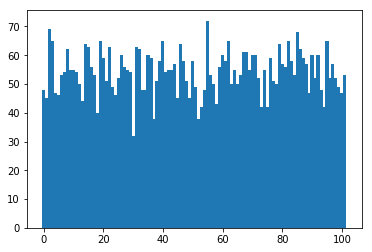

In [9]:
"""

Check class distribution in training data loader
"""

d={}
for data, label in tqdm(train_full_data_loader):
        for i in label:
            if i.item() in d: d[i.item()] += 1
            else: d[i.item()] = 1      
x = [int(el) for el in d.keys()]
y = [d[el] for el in d.keys()]
plt.bar(x, y, 1.05)
plt.show()

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
class_to_name = {}
with open('cat_to_name.json', 'r') as f:
    tmp = json.load(f)
for k in tmp:
    v = tmp[k]
    k = k.encode("ascii","replace")
    v = v.encode("ascii","replace")
    class_to_name[k]=v

## Visualize some data

In [11]:
def imshow(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    std = np.asarray(std)
    img = t.Normalize((-np.asarray(mean) / std), (1.0 / std))(img)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

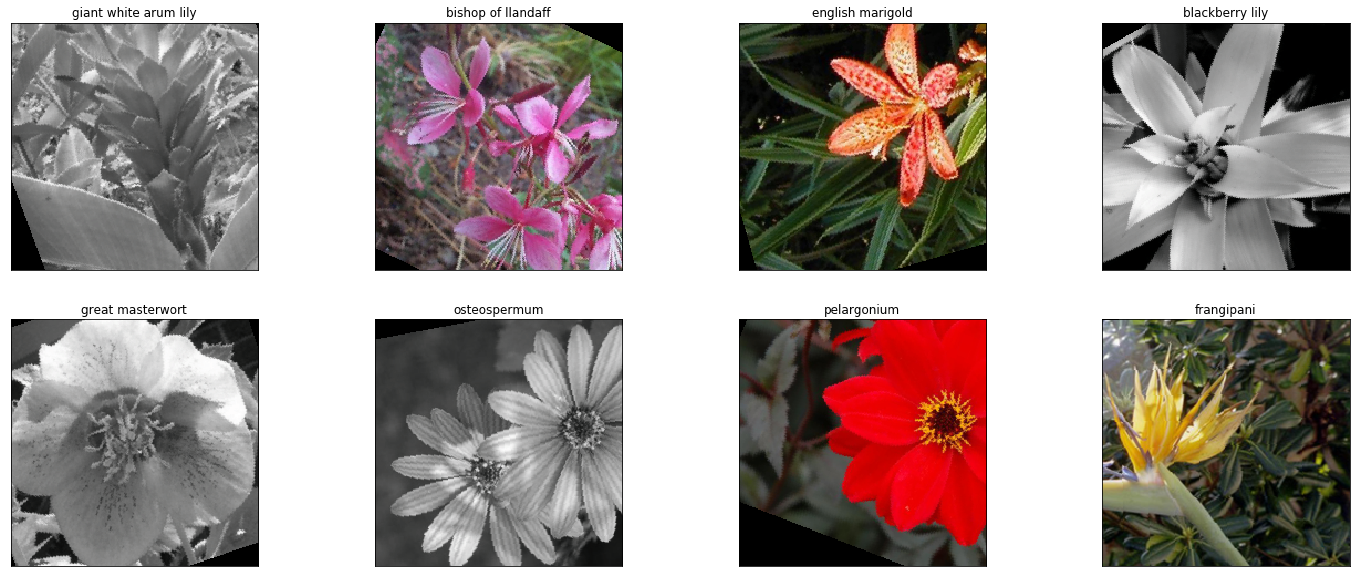

In [12]:
dataiter = iter(train_full_data_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 10))

for i in np.arange(8):
    ax = fig.add_subplot(2, 8/2, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(class_to_name[str(labels[i].item()+1)])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [13]:
"""

Load model
"""

def get_model():
    print("Loading model...")
    model = models.resnet152(pretrained=True)
    for n, p in model.named_parameters():
        p.requires_grad = False
    model.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
    nn.init.xavier_normal_(model.fc.weight)
    model.fc.bias.data.fill_(0)
    model.fc.weight.requires_grad = True
    model.fc.bias.requires_grad = True
    for n, p in model.named_parameters():
        if p.requires_grad:
            print("Parameter that will be trained: {}".format(n))
    print("Model loaded!!!")
    return model

In [14]:
"""

Computes and stores the average and current value
"""
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [15]:
def accuracy(output, target, topk, accuracy_valuation_log=False):
    """

    Computes the precision@k for the specified values of k

    :param output: the output of the model
    :param target: id of the target class
    :param topk: list of top k scores we want. It returns at least the top1k score
    :return: top k scores
    """
    maxk = max(topk)
    # _    --> k highest values from the output tensor
    # pred --> indexes of the k highest values in the output tensor
    _, pred = output.topk(maxk, 1, True, True)
    # It is simply the transpose of pred
    pred = pred.t()
    # check in which cases the target class index is in the top k vector
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    if accuracy_valuation_log:
        print("maxk", maxk)
        print("Pred", pred)
        print("Correct", correct)
        print("len target", len(target))
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / len(target)))
    return res


def make_plot(t_loss, t_acc, v_loss, v_acc, figsize=(20, 5)):
    xt = np.arange(len(t_loss))
    vx = np.linspace(0, xt[-1], len(v_loss))
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(xt, t_loss, label='Train', marker='^')
    plt.plot(vx, v_loss, label='Valid', marker='*')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(xt, t_acc, label='Train', marker='^')
    plt.plot(vx, v_acc, label='Valid', marker='*')
    plt.ylabel('Accuracy@1')
    plt.xlabel('Epochs')
    plt.legend()

In [16]:
def train(epoch, model, data_loader, optimizer, criterion, batch_accumulation_steps, 
          cuda_available, log, t_loss, t_acc):
    
    model.train()
    
    loss_ = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    optimizer.zero_grad()
    j = 1
    
    for batch_idx, (data, target) in enumerate(data_loader):
        
        if cuda_available:
            data   = data.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
        
        logits = model.forward(data)
        loss = criterion(logits, target)
        
        prec1, prec5 = accuracy(output=logits, target=target, topk=(1, 5), accuracy_valuation_log=False)
        loss_.update(loss.item())
        top1.update(prec1.item())
        top5.update(prec5.item())

        loss.backward()
        if j % batch_accumulation_steps == 0:
            j = 1
            optimizer.step()
            optimizer.zero_grad()
        else:
            j += 1
            
        if batch_idx % log == 0:
            t_loss.append(loss_.avg)
            t_acc.append(top1.avg)
            print("Training epoch [{}], iteration [{}]/[{}]: ======> Loss: {:.4f} --- Acc@1: {:.2f}%".format(
                    epoch, batch_idx, len(data_loader), loss_.avg, top1.avg))

In [17]:
def validate(epoch, model, criterion, data_loader, cuda_available, v_loss, v_acc, v_acc5):
    
    model.eval()
    
    loss_ = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            
            if cuda_available:
                data = data.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)

            logits = model.forward(data.cuda())
            loss = criterion(logits, target.cuda())

            prec1, prec5 = accuracy(output=logits, target=target, topk=(1, 5), accuracy_valuation_log=False)
            loss_.update(loss.item())
            top1.update(prec1.item())
            top5.update(prec5.item())
    
    print("Validation epoch {}: ======> Loss: {:.4f} --- Acc@1: {:.2f}%".format(epoch, loss_.avg, top1.avg))
    v_loss.append(loss_.avg)
    v_acc.append(top1.avg)
    v_acc5.append(top5.avg)
    return top1.avg, loss_.avg

In [18]:
def test(model, criterion, data_loader, cuda_available):
    
    model.eval()
    
    loss_ = AverageMeter()
    top1 = AverageMeter()

    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(data_loader), desc='Model Test', total=len(data_loader)):
            
            if cuda_available:
                data = data.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)

            logits = model.forward(data)
            loss = criterion(logits, target)

            prec1, prec5 = accuracy(output=logits, target=target, topk=(1, 5), accuracy_valuation_log=False)
            loss_.update(loss.item())
            top1.update(prec1.item())
    
    print("Test: ======> Loss: {:.4f} --- Acc@1: {:.2f}%".format(loss_.avg, top1.avg))

## 1st sanity check: overfit the model on a single batch

In [19]:
model = get_model()
if cuda_available:
    model.cuda()
print("Model is on cuda: {}".format(next(model.parameters()).is_cuda))

optimizer = torch.optim.SGD(model.parameters(), lr=1.e-1, weight_decay=1.e-4)
criterion = nn.CrossEntropyLoss()
if cuda_available:
    criterion.cuda()

epochs = 20
validate_first = True
batch_accumulation_steps = 1

t_loss = []
t_acc = []
v_loss = []
v_acc = []

img, label = iter(train_data_loader).next()
if cuda_available:
    img = img.cuda(non_blocking=True)
    label = label.cuda(non_blocking=True)
optimizer.zero_grad()
for epoch in range(1, epochs+1):
    with torch.no_grad():
        model.eval()
        for data, target in valid_data_loader:
            if cuda_available:
                data = data.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)
            output = model(data)
            loss = criterion(output, target)
            prec1, prec5 = accuracy(output=output, target=target.cuda(), topk=(1, 5), accuracy_valuation_log=False)
            v_loss.append(loss.item())
            v_acc.append(prec1[0].item())
        print("Valid epoch {}: ======> Loss: {:.4f} --- Acc@1: {:.2f}%".format(epoch, loss.item(), prec1[0].item()))

    model.train()
    output = model(img)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    prec1, prec5 = accuracy(output=output, target=label, topk=(1, 5), accuracy_valuation_log=False)
    t_loss.append(loss.item())
    t_acc.append(prec1[0].item())
    print("Train epoch {}: ======> Loss: {:.4f} --- Acc@1: {:.2f}%".format(epoch, loss.item(), prec1[0].item()))

Loading model...
Parameter that will be trained: fc.weight
Parameter that will be trained: fc.bias
Model loaded!!!
Model is on cuda: True
Valid epoch 1: ======> Loss: 4.8143 --- Acc@1: 0.00%
Train epoch 1: ======> Loss: 4.5608 --- Acc@1: 0.00%
Valid epoch 2: ======> Loss: 7.8297 --- Acc@1: 0.00%
Train epoch 2: ======> Loss: 1.3586 --- Acc@1: 75.00%
Valid epoch 3: ======> Loss: 8.1426 --- Acc@1: 0.00%
Train epoch 3: ======> Loss: 0.9830 --- Acc@1: 87.50%
Valid epoch 4: ======> Loss: 8.9597 --- Acc@1: 0.00%
Train epoch 4: ======> Loss: 0.7263 --- Acc@1: 68.75%
Valid epoch 5: ======> Loss: 9.3900 --- Acc@1: 0.00%
Train epoch 5: ======> Loss: 1.1081 --- Acc@1: 62.50%
Valid epoch 6: ======> Loss: 9.8464 --- Acc@1: 0.00%
Train epoch 6: ======> Loss: 1.5289 --- Acc@1: 75.00%
Valid epoch 7: ======> Loss: 8.9648 --- Acc@1: 0.00%
Train epoch 7: ======> Loss: 0.3070 --- Acc@1: 87.50%
Valid epoch 8: ======> Loss: 8.5894 --- Acc@1: 0.00%
Train epoch 8: ======> Loss: 0.0457 --- Acc@1: 100.00%
Valid 

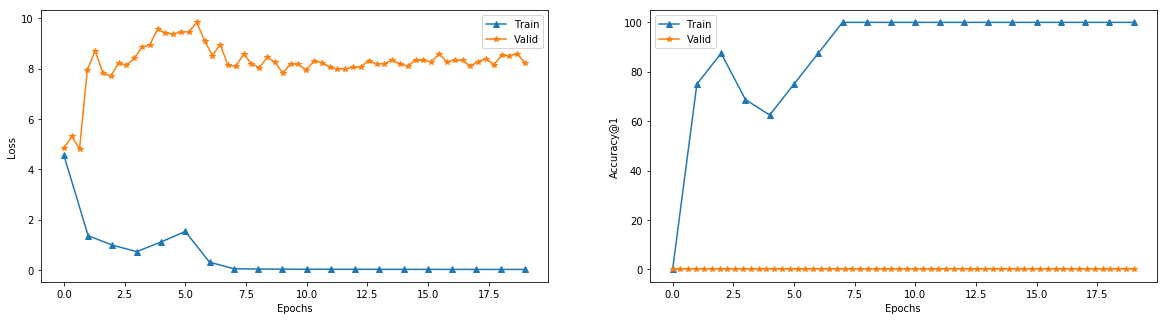

In [20]:
make_plot(t_loss, t_acc, v_loss, v_acc)

## 2nd sanity check: overfit the model on a small data set

In [21]:
torch.cuda.empty_cache()

In [25]:
model = get_model()
if cuda_available:
    model.cuda()
print("Model is on cuda: {}".format(next(model.parameters()).is_cuda))

optimizer = torch.optim.SGD(model.parameters(), lr=8.e-2, weight_decay=1.e-4)
criterion = nn.CrossEntropyLoss()
if cuda_available:
    criterion.cuda()

epochs = 40
validate_first = True
batch_accumulation_steps = 2

t_loss = []
t_acc = []
v_loss = []
v_acc = []
v_acc5 = []

if validate_first:
    validate(0, model, criterion, valid_data_loader, cuda_available,v_loss, v_acc, v_acc5)

for epoch in range(1, epochs+1):
    train(epoch, model, train_data_loader, optimizer, criterion, batch_accumulation_steps, 
          cuda_available=cuda_available, log=3, t_loss=t_loss, t_acc=t_acc)
    validate(epoch, model, criterion, valid_data_loader, cuda_available, v_loss, v_acc, v_acc5)

Loading model...
Parameter that will be trained: fc.weight
Parameter that will be trained: fc.bias
Model loaded!!!
Model is on cuda: True
Validation epoch 0: ======> Loss: 5.0080 --- Acc@1: 0.00%
Training epoch [1], iteration [0]/[15]: ======> Loss: 4.9031 --- Acc@1: 6.25%
Training epoch [1], iteration [3]/[15]: ======> Loss: 7.2753 --- Acc@1: 1.56%
Training epoch [1], iteration [6]/[15]: ======> Loss: 11.6927 --- Acc@1: 0.89%
Training epoch [1], iteration [9]/[15]: ======> Loss: 12.6474 --- Acc@1: 0.62%
Training epoch [1], iteration [12]/[15]: ======> Loss: 14.6419 --- Acc@1: 0.48%
Validation epoch 1: ======> Loss: 16.6671 --- Acc@1: 0.00%
Training epoch [2], iteration [0]/[15]: ======> Loss: 12.6276 --- Acc@1: 0.00%
Training epoch [2], iteration [3]/[15]: ======> Loss: 24.0811 --- Acc@1: 0.00%
Training epoch [2], iteration [6]/[15]: ======> Loss: 21.7281 --- Acc@1: 0.00%
Training epoch [2], iteration [9]/[15]: ======> Loss: 22.1297 --- Acc@1: 2.50%
Training epoch [2], iteration [12]/

Training epoch [18], iteration [9]/[15]: ======> Loss: 6.6721 --- Acc@1: 59.38%
Training epoch [18], iteration [12]/[15]: ======> Loss: 6.0561 --- Acc@1: 60.10%
Validation epoch 18: ======> Loss: 9.2268 --- Acc@1: 0.00%
Training epoch [19], iteration [0]/[15]: ======> Loss: 0.5019 --- Acc@1: 75.00%
Training epoch [19], iteration [3]/[15]: ======> Loss: 0.8209 --- Acc@1: 76.56%
Training epoch [19], iteration [6]/[15]: ======> Loss: 1.5172 --- Acc@1: 68.75%
Training epoch [19], iteration [9]/[15]: ======> Loss: 3.2220 --- Acc@1: 64.38%
Training epoch [19], iteration [12]/[15]: ======> Loss: 3.2526 --- Acc@1: 62.02%
Validation epoch 19: ======> Loss: 9.6782 --- Acc@1: 0.00%
Training epoch [20], iteration [0]/[15]: ======> Loss: 0.6727 --- Acc@1: 75.00%
Training epoch [20], iteration [3]/[15]: ======> Loss: 0.7356 --- Acc@1: 79.69%
Training epoch [20], iteration [6]/[15]: ======> Loss: 1.5493 --- Acc@1: 76.79%
Training epoch [20], iteration [9]/[15]: ======> Loss: 2.6250 --- Acc@1: 70.62%


Training epoch [36], iteration [6]/[15]: ======> Loss: 0.2722 --- Acc@1: 94.64%
Training epoch [36], iteration [9]/[15]: ======> Loss: 0.3623 --- Acc@1: 90.62%
Training epoch [36], iteration [12]/[15]: ======> Loss: 0.3276 --- Acc@1: 91.35%
Validation epoch 36: ======> Loss: 11.4473 --- Acc@1: 0.00%
Training epoch [37], iteration [0]/[15]: ======> Loss: 0.3245 --- Acc@1: 87.50%
Training epoch [37], iteration [3]/[15]: ======> Loss: 0.2165 --- Acc@1: 93.75%
Training epoch [37], iteration [6]/[15]: ======> Loss: 0.4524 --- Acc@1: 86.61%
Training epoch [37], iteration [9]/[15]: ======> Loss: 0.4744 --- Acc@1: 86.88%
Training epoch [37], iteration [12]/[15]: ======> Loss: 0.4378 --- Acc@1: 87.02%
Validation epoch 37: ======> Loss: 10.0192 --- Acc@1: 0.00%
Training epoch [38], iteration [0]/[15]: ======> Loss: 0.1147 --- Acc@1: 100.00%
Training epoch [38], iteration [3]/[15]: ======> Loss: 0.1932 --- Acc@1: 93.75%
Training epoch [38], iteration [6]/[15]: ======> Loss: 0.3414 --- Acc@1: 91.0

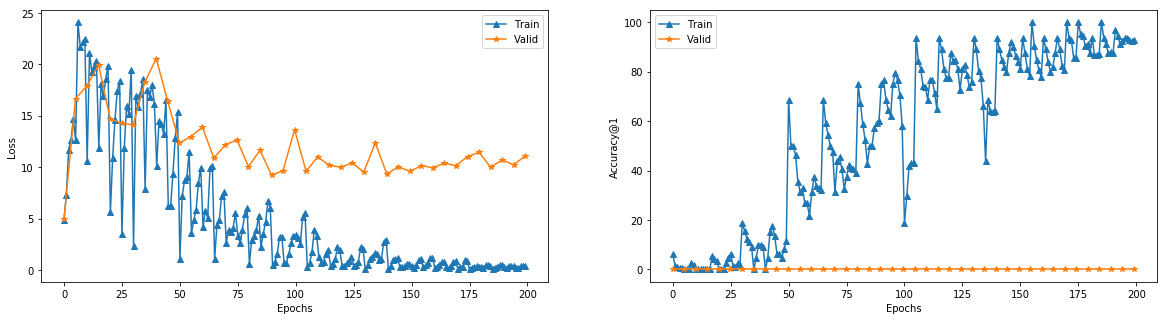

In [26]:
make_plot(t_loss, t_acc, v_loss, v_acc)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [28]:
def save_model_checkpoint(ckp_folder, model, optimzier, epoch, acc1, acc5, class_to_idx):
    state_dict = {
        'epoch': epoch + 1,
        'arch': model.__class__.__name__,
        'model_state_dict': model.state_dict(),
        'top1.avg': acc1,
        'top5.avg': acc5,
        'optimizer_state_dict': optimizer.state_dict(),
        'class_to_idx': class_to_idx
    }
    checkpoint_file_name = 'model_flowers_checkpoint_at_epoch_' + str(epoch + 1) + '.pth.tar'
    file_name = os.path.join(ckp_folder, checkpoint_file_name)
    print('Saving model in: {}'.format(file_name))
    torch.save(state_dict, file_name)
    print("Model saved!!!")

## Train the model

In [29]:
torch.cuda.empty_cache()

In [30]:
print('Number of training images: {}\nNumber of validation images: {}\nNumber of test images: {}'
      .format(len(train_full_data_loader.dataset.imgs), len(valid_full_data_loader.dataset.imgs),
              len(test_data_loader.dataset.imgs)))

Number of training images: 5532
Number of validation images: 818
Number of test images: 1020


In [63]:
ckp_folder = './model_checkpoints/'+time.strftime("%Y-%m-%d_%H.%M.%S")
if not os.path.isdir(ckp_folder):
    os.makedirs(ckp_folder)

In [64]:
model = get_model()
if cuda_available:
    model.cuda()
print("Model is on cuda: {}".format(next(model.parameters()).is_cuda))

optimizer = torch.optim.SGD(model.parameters(), lr=8.e-2, weight_decay=1.e-4)
criterion = nn.CrossEntropyLoss()
if cuda_available:
    criterion.cuda()

epochs = 50
validate_first = True
batch_accumulation_steps = 4
best_acc = 0

t_loss = []
t_acc = []
v_loss = []
v_acc = []
v_acc5 = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, 
                                                       patience=3, verbose=True, min_lr=1.e-5, threshold=0.1)

Loading model...
Parameter that will be trained: fc.weight
Parameter that will be trained: fc.bias
Model loaded!!!
Model is on cuda: True


In [65]:
if validate_first:
    validate(0, model, criterion, valid_full_data_loader, cuda_available, v_loss, v_acc, v_acc5)

for epoch in range(1, epochs+1):
    
    train(epoch, model, train_full_data_loader, optimizer, criterion, batch_accumulation_steps, 
          cuda_available=cuda_available, log=80, t_loss=t_loss, t_acc=t_acc)
    
    val_acc, val_loss = validate(epoch, model, criterion, valid_full_data_loader, cuda_available, 
                                 v_loss, v_acc, v_acc5)
    
    scheduler.step(val_loss, epoch)
    
    if best_acc < val_acc:
        print('Accuracy increased ({:.2f}% --> {:.2f}%)'.format(best_acc, val_acc))
        best_acc = val_acc
        save_model_checkpoint(ckp_folder, model, optimizer, epoch+1, best_acc, v_acc5[-1], 
                              train_full_data_loader.dataset.class_to_idx)

Validation epoch 0: ======> Loss: 5.0079 --- Acc@1: 0.72%
Training epoch [1], iteration [0]/[346]: ======> Loss: 5.0810 --- Acc@1: 0.00%
Training epoch [1], iteration [80]/[346]: ======> Loss: 14.0404 --- Acc@1: 3.78%
Training epoch [1], iteration [160]/[346]: ======> Loss: 16.5045 --- Acc@1: 8.19%
Training epoch [1], iteration [240]/[346]: ======> Loss: 15.7874 --- Acc@1: 13.28%
Training epoch [1], iteration [320]/[346]: ======> Loss: 13.5127 --- Acc@1: 20.87%
Validation epoch 1: ======> Loss: 3.9043 --- Acc@1: 53.12%
Accuracy increased (0.00% --> 53.12%)
Saving model in: ./model_checkpoints/2019-01-04_18.26.04/model_flowers_checkpoint_at_epoch_3.pth.tar
Model saved!!!
Training epoch [2], iteration [0]/[346]: ======> Loss: 2.4611 --- Acc@1: 56.25%
Training epoch [2], iteration [80]/[346]: ======> Loss: 2.2332 --- Acc@1: 61.88%
Training epoch [2], iteration [160]/[346]: ======> Loss: 2.0365 --- Acc@1: 63.16%
Training epoch [2], iteration [240]/[346]: ======> Loss: 1.9566 --- Acc@1: 64.

Training epoch [15], iteration [240]/[346]: ======> Loss: 0.2488 --- Acc@1: 93.49%
Training epoch [15], iteration [320]/[346]: ======> Loss: 0.2564 --- Acc@1: 93.36%
Validation epoch 15: ======> Loss: 0.3161 --- Acc@1: 92.19%
Training epoch [16], iteration [0]/[346]: ======> Loss: 0.0687 --- Acc@1: 100.00%
Training epoch [16], iteration [80]/[346]: ======> Loss: 0.2494 --- Acc@1: 93.52%
Training epoch [16], iteration [160]/[346]: ======> Loss: 0.2671 --- Acc@1: 92.82%
Training epoch [16], iteration [240]/[346]: ======> Loss: 0.2689 --- Acc@1: 92.66%
Training epoch [16], iteration [320]/[346]: ======> Loss: 0.2721 --- Acc@1: 92.70%
Validation epoch 16: ======> Loss: 0.3068 --- Acc@1: 92.19%
Training epoch [17], iteration [0]/[346]: ======> Loss: 0.2620 --- Acc@1: 93.75%
Training epoch [17], iteration [80]/[346]: ======> Loss: 0.2770 --- Acc@1: 92.28%
Training epoch [17], iteration [160]/[346]: ======> Loss: 0.2809 --- Acc@1: 92.59%
Training epoch [17], iteration [240]/[346]: ======> Los

Training epoch [31], iteration [320]/[346]: ======> Loss: 0.2547 --- Acc@1: 93.11%
Validation epoch 31: ======> Loss: 0.3018 --- Acc@1: 92.55%
Training epoch [32], iteration [0]/[346]: ======> Loss: 0.1020 --- Acc@1: 100.00%
Training epoch [32], iteration [80]/[346]: ======> Loss: 0.2402 --- Acc@1: 94.83%
Training epoch [32], iteration [160]/[346]: ======> Loss: 0.2420 --- Acc@1: 93.94%
Training epoch [32], iteration [240]/[346]: ======> Loss: 0.2526 --- Acc@1: 93.57%
Training epoch [32], iteration [320]/[346]: ======> Loss: 0.2551 --- Acc@1: 93.38%
Validation epoch 32: ======> Loss: 0.3006 --- Acc@1: 92.91%
Training epoch [33], iteration [0]/[346]: ======> Loss: 0.2250 --- Acc@1: 93.75%
Training epoch [33], iteration [80]/[346]: ======> Loss: 0.2453 --- Acc@1: 93.36%
Training epoch [33], iteration [160]/[346]: ======> Loss: 0.2499 --- Acc@1: 93.28%
Training epoch [33], iteration [240]/[346]: ======> Loss: 0.2655 --- Acc@1: 92.95%
Training epoch [33], iteration [320]/[346]: ======> Los

Training epoch [49], iteration [80]/[346]: ======> Loss: 0.2530 --- Acc@1: 93.21%
Training epoch [49], iteration [160]/[346]: ======> Loss: 0.2606 --- Acc@1: 92.93%
Training epoch [49], iteration [240]/[346]: ======> Loss: 0.2607 --- Acc@1: 93.15%
Training epoch [49], iteration [320]/[346]: ======> Loss: 0.2611 --- Acc@1: 93.03%
Validation epoch 49: ======> Loss: 0.2953 --- Acc@1: 92.43%
Training epoch [50], iteration [0]/[346]: ======> Loss: 0.4824 --- Acc@1: 87.50%
Training epoch [50], iteration [80]/[346]: ======> Loss: 0.2563 --- Acc@1: 92.98%
Training epoch [50], iteration [160]/[346]: ======> Loss: 0.2468 --- Acc@1: 93.48%
Training epoch [50], iteration [240]/[346]: ======> Loss: 0.2579 --- Acc@1: 93.26%
Training epoch [50], iteration [320]/[346]: ======> Loss: 0.2600 --- Acc@1: 93.32%
Validation epoch 50: ======> Loss: 0.3073 --- Acc@1: 91.83%


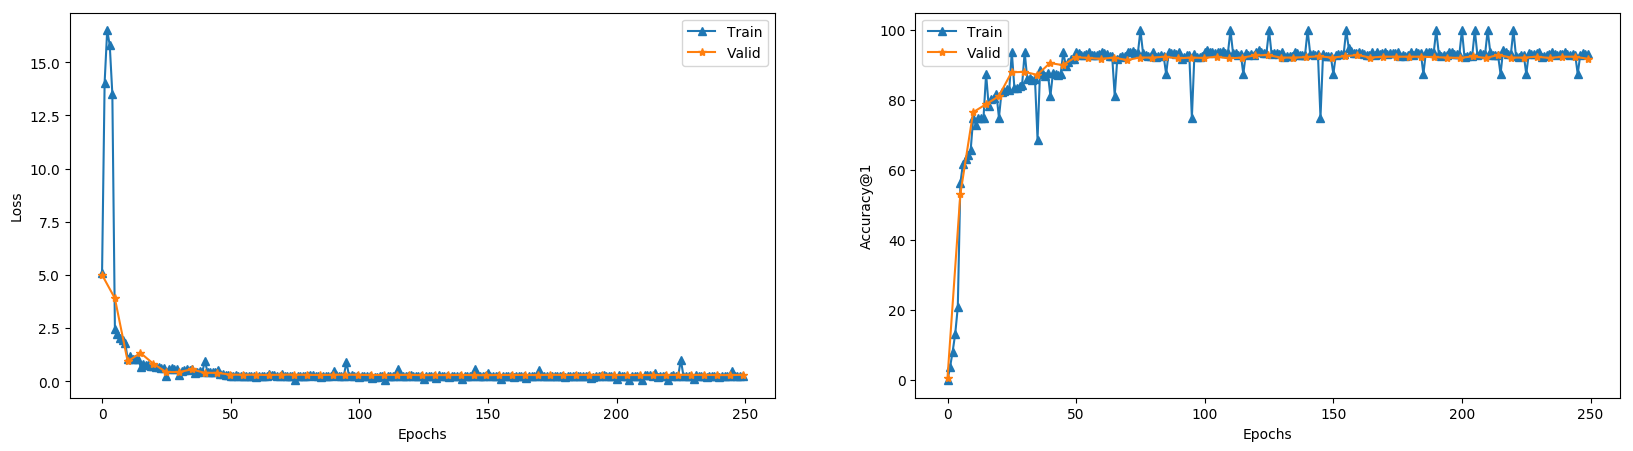

In [66]:
make_plot(t_loss, t_acc, v_loss, v_acc)

In [83]:
"""

Test the model
"""

test(model, criterion, test_data_loader, cuda_available)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdNb2RlbCBUZXN0JywgbWF4PTY0LCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHRoPXXigKY=



Test: ======> Loss: 0.1075 --- Acc@1: 97.27%


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [118]:
def load_model(path_to_model_checkpoint, cuda_available):
    model = get_model()
    if cuda_available:
        print("Model on cuda")
        checkpoint = torch.load(path_to_model_checkpoint)
        model.cuda()
    else:
        print("Model on cpu")
        checkpoint = torch.load(path_to_model_checkpoint, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    class_to_idx = checkpoint['class_to_idx']
    return model, class_to_idx, checkpoint['model_state_dict']

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [32]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    tr = t.Compose([
                t.Resize(256),
                t.CenterCrop(224),
                t.ToTensor(),
                t.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    return tr(image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [33]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [84]:
def predict(image_path, model, topk=5):
    ''' 
    
    Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = Image.open(image_path)
    img = process_image(image)
    img = img[np.newaxis, :]
    model.eval()
    if torch.cuda.is_available():
        img = img.cuda(non_blocking=True)
        model.cuda()
    output = model(img)
    output = F.softmax(output, dim=1)
    probs, indices = output.topk(topk, dim=1, largest=True, sorted=True)
    return probs, indices

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [119]:
path_to_model_checkpoint = "./model_checkpoints/2018-12-27_19.00.00/model_flowers_checkpoint_at_epoch_13.pth.tar"
model, class_to_idx, d= load_model(path_to_model_checkpoint=path_to_model_checkpoint, 
                                 cuda_available=False)

Loading model...
Parameter that will be trained: fc.weight
Parameter that will be trained: fc.bias
Model loaded!!!
Model on cpu


In [122]:
torch.__version__

'1.0.0'

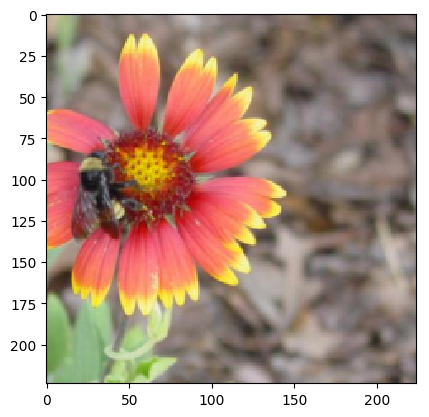

In [113]:
img_path, label = test_data_loader.dataset.imgs[20]
#img_path = './flower_data/valid/28/image_05265.jpg'
img = process_image(Image.open(img_path))
ax = imshow(img)
plt.show()

In [114]:
idx_to_class = {v: k for k, v in class_to_idx.iteritems()}

probs, indices = predict(img_path, model)
indices = indices.detach().cpu().numpy()[0]
classes = [idx_to_class[k] for k in indices]
print("Output classes: {}".format(classes))
names = [class_to_name[k] for k in classes]
print("Output names: {}".format(names))

Output classes: ['100', '17', '66', '63', '71']
Output names: ['blanket flower', 'purple coneflower', 'osteospermum', 'black-eyed susan', 'gazania']


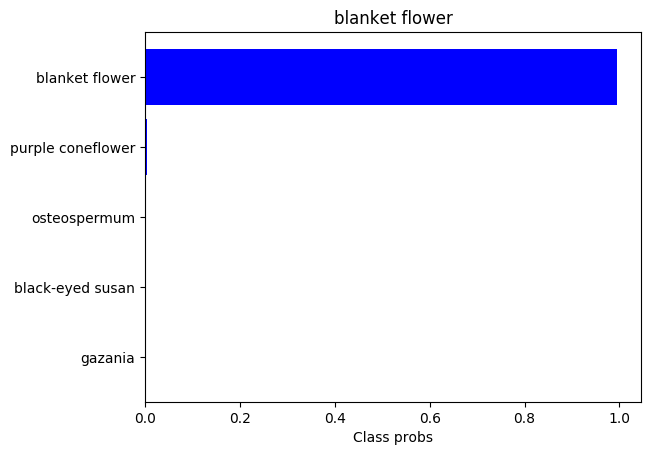

(class, prob): blanket flower, 0.996
(class, prob): purple coneflower, 0.004
(class, prob): osteospermum, 0.000
(class, prob): black-eyed susan, 0.000
(class, prob): gazania, 0.000


In [115]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(names))
performance = probs.detach().cpu().numpy()[0]

ax.barh(y_pos, performance, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel('Class probs')
ax.set_title(names[0])

plt.show()

for i in range(len(performance)):
    print("(class, prob): {}, {:.3f}".format(names[i], performance[i]))